<a href="https://colab.research.google.com/github/SophieShin/Python/blob/main/FX_and_Index(TradingVolume)__VAR%2CGrangerCausality%2CImpulseResponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


In [78]:
df = pd.read_csv("/content/IndexandFX.csv")


In [79]:
df

,Date,TradingVolume,FX
0,20000104,195898.0,1123.0
1,20000105,257696.0,1134.0
2,20000106,203523.0,1147.0
3,20000107,215664.0,1139.5
4,20000110,240175.0,1133.5
...,...,...,...
6172,20250109,404290.0,1460.5
6173,20250110,377586.0,1465.0
6174,20250113,578565.0,1470.8
6175,20250114,414487.0,1463.2


In [80]:
df['log_Fx'] = np.log(df['FX'])
df['log_TradingVolume'] = np.log(df['TradingVolume'])

In [81]:
df['dlog_Fx'] = df['log_Fx'].diff()
df['dlog_TradingVolume'] = df['log_TradingVolume'].diff()

In [84]:
var_data = df.dropna()

In [92]:
var_data=df[['dlog_Fx', 'dlog_TradingVolume']].dropna()

In [93]:
model = VAR(var_data)

# 최대 10시차까지 비교해보고 정보기준 확인
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.36      -13.36   1.573e-06      -13.36
1       -13.46      -13.46   1.421e-06      -13.46
2       -13.51      -13.50   1.358e-06      -13.51
3       -13.54      -13.52   1.319e-06      -13.53
4       -13.55      -13.53   1.306e-06      -13.54
5       -13.55     -13.53*   1.300e-06      -13.55
6       -13.55      -13.52   1.301e-06      -13.54
7       -13.56      -13.52   1.296e-06      -13.54
8       -13.56      -13.52   1.289e-06      -13.55
9       -13.56      -13.52   1.288e-06      -13.55
10     -13.57*      -13.52  1.284e-06*     -13.55*
--------------------------------------------------


In [94]:
lag_order = 5

In [96]:
var_res = model.fit(lag_order)

In [97]:
print(var_res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Nov, 2025
Time:                     21:30:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.5302
Nobs:                     6163.00    HQIC:                  -13.5458
Log likelihood:           24299.3    FPE:                1.29868e-06
AIC:                     -13.5542    Det(Omega_mle):     1.29406e-06
--------------------------------------------------------------------
Results for equation dlog_Fx
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000045         0.000081            0.552           0.581
L1.dlog_Fx                    0.003944         0.012749            0.309           0.757
L1.dlog_TradingVolume     

In [99]:
# 마지막 관측값 기준으로 향후 h-step 예측
h = 10  # 10기간 예측
forecast = var_res.forecast(y=var_data.values[-lag_order:], steps=h)

# 예측 결과를 DataFrame으로 정리
forecast_index = pd.date_range(start=var_data.index[-1], periods=h+1, freq='D')[1:]
# Select only the dlog_Fx and dlog_TradingVolume forecasts (assuming they are the last two columns)
# If the order changes, these indices might need adjustment
forecast_df = pd.DataFrame(forecast[:, [0, 1]], # Slicing forecast to get only the relevant columns
                           index=forecast_index,
                           columns=['dlog_fx_hat', 'dlog_vol_hat'])

print(forecast_df.head())

                               dlog_fx_hat  dlog_vol_hat
1970-01-02 00:00:00.000006176    -0.000576     -0.104537
1970-01-03 00:00:00.000006176     0.000284     -0.014075
1970-01-04 00:00:00.000006176     0.000100     -0.005821
1970-01-05 00:00:00.000006176     0.000136      0.020095
1970-01-06 00:00:00.000006176     0.000075     -0.009390


In [100]:
var_res.resid.head()


,dlog_Fx,dlog_TradingVolume
6,-0.000303,-0.048834
7,-0.008877,-0.037547
8,-0.008767,-0.010150
9,-0.003166,-0.079688
10,0.004582,-0.045086


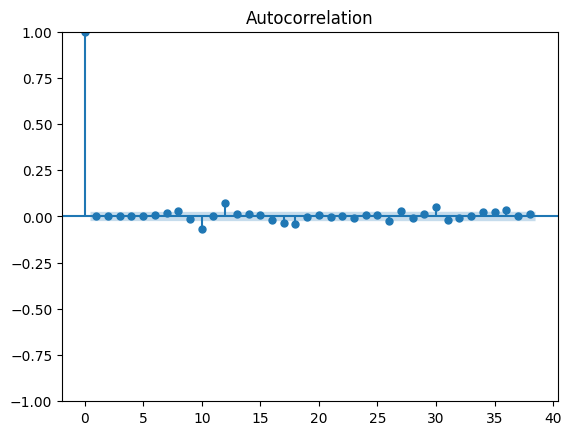

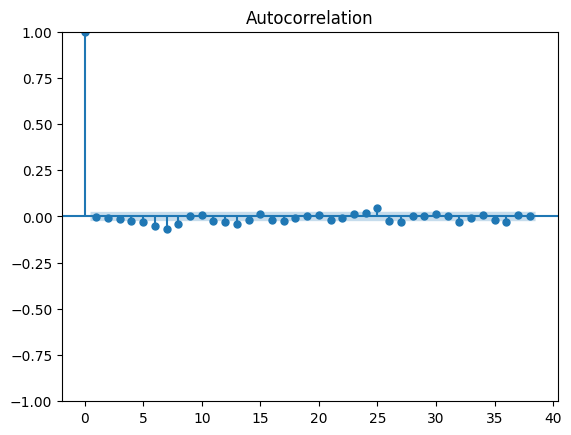

In [108]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(var_res.resid['dlog_Fx'])

sm.graphics.tsa.plot_acf(var_res.resid['dlog_TradingVolume'])
plt.show()

In [104]:
var_res.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.6443612723296296
0.6443612723296296
0.43559866441071043
0.43559866441071043
0.5677806134016057
0.5677806134016057
0.21776195763659814
0.21776195763659814
0.5656276166981112
0.3886302201327166


np.True_

In [ ]:
sm.graphics.tsa.plot_acf(var_res.resid['dlog_Fx'])
sm.graphics.tsa.plot_acf(var_res.resid['dlog_TradingVolume'])

In [111]:
var_res.test_causality('dlog_Fx', ['dlog_TradingVolume'], kind='f').summary()


Test statistic,Critical value,p-value,df
0.4652,2.215,0.802,"(5, 12304)"


In [110]:
var_res.test_causality('dlog_TradingVolume', ['dlog_Fx'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.602,2.215,0.156,"(5, 12304)"


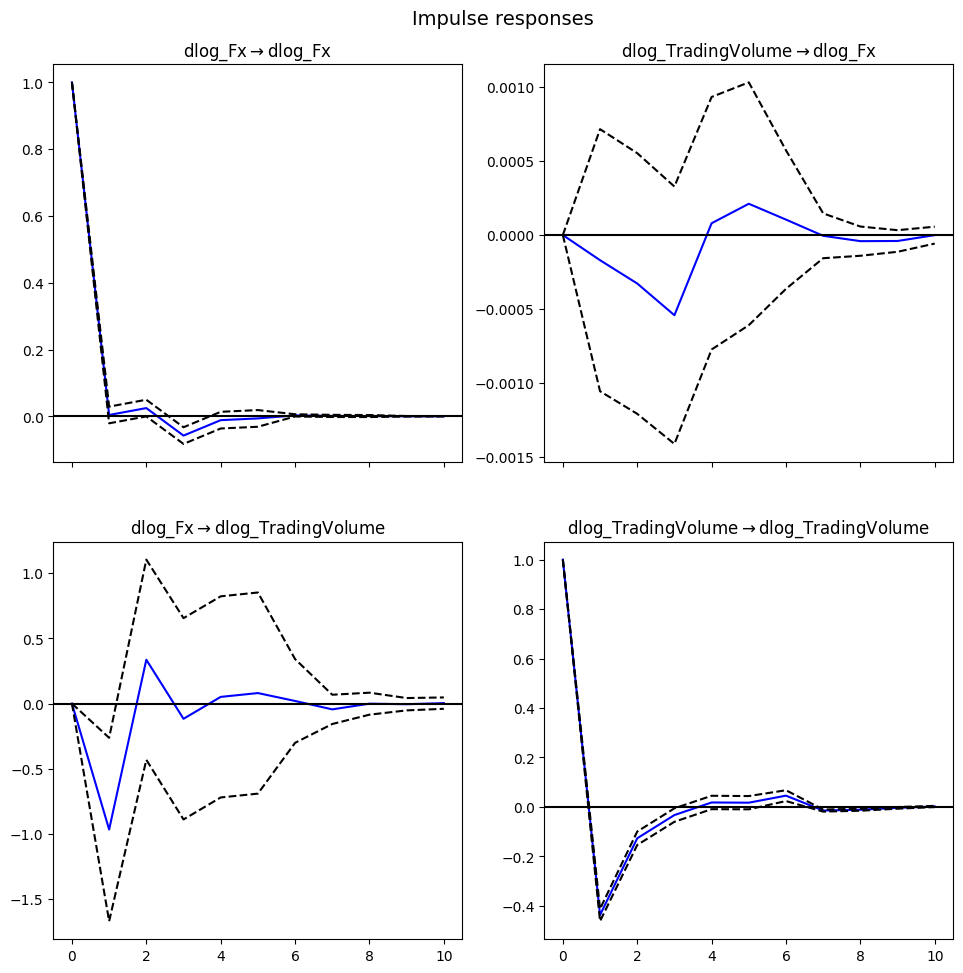

In [112]:
# 1) IRF 객체 생성 (10 스텝)
irf = var_res.irf(10)

# 2) 기본 플롯
irf.plot(orth=False)   # orth=True로 하면 직교화(Cholesky) 충격
plt.show()

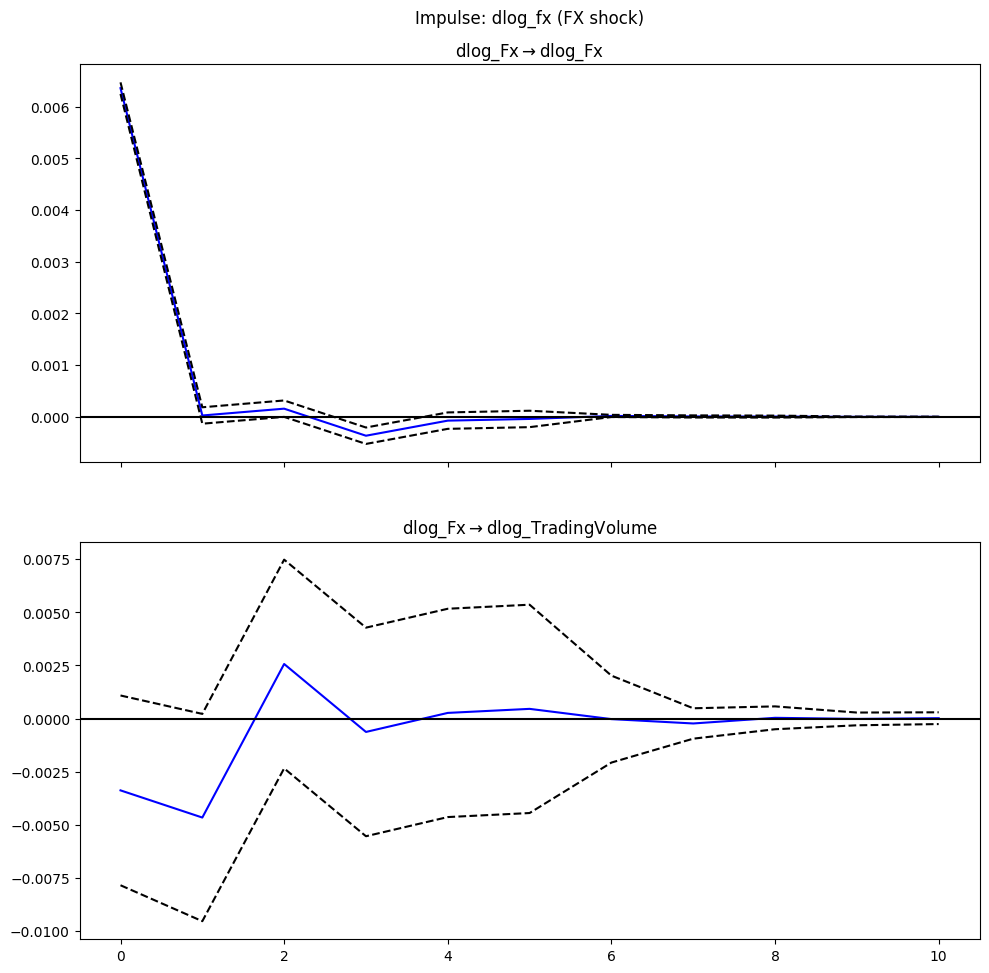

In [114]:
irf.plot(impulse='dlog_Fx', orth=True)
plt.suptitle("Impulse: dlog_fx (FX shock)")
plt.show()

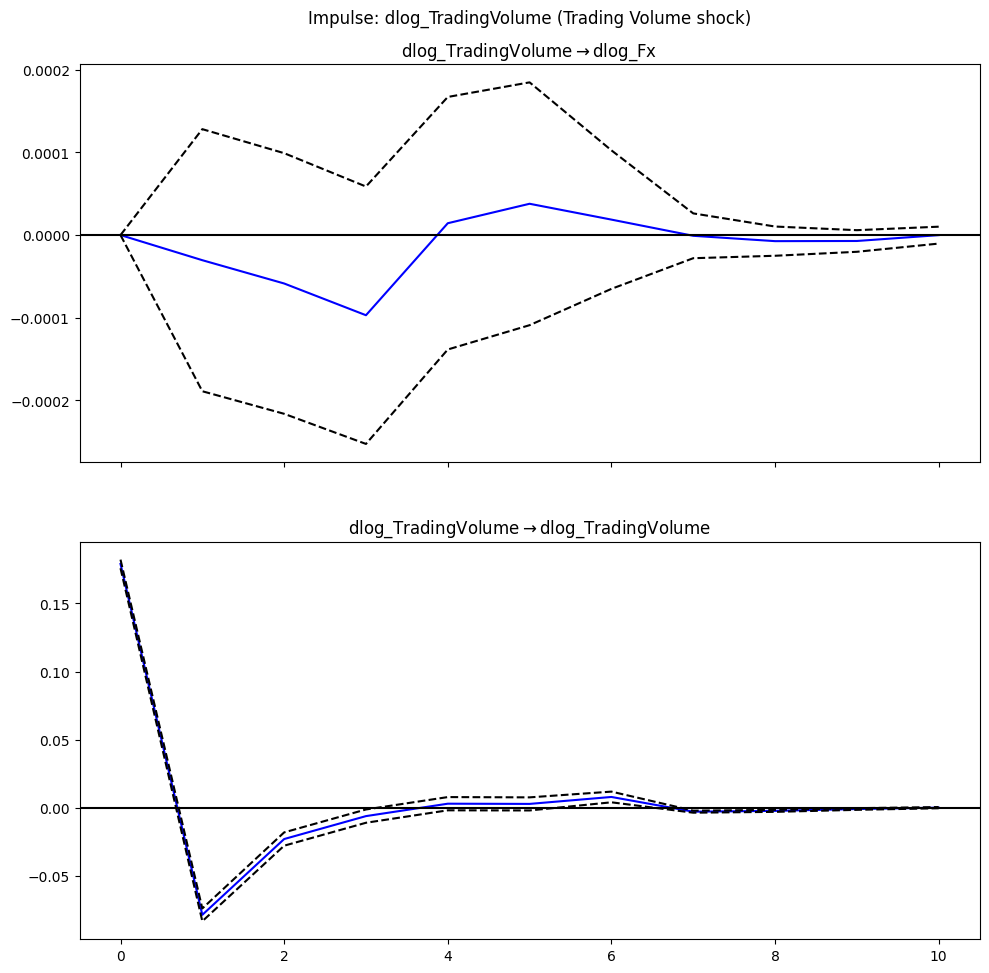

In [115]:
irf.plot(impulse='dlog_TradingVolume', orth=True)
plt.suptitle("Impulse: dlog_TradingVolume (Trading Volume shock)")
plt.show()